In [ ]:
import torch
from torch import nn
import gdown
import matplotlib.pyplot as plt
import os

In [ ]:
LATENT_VECTOR_DIM = 100
NUM_ROWS = 16  # ile wierszy i kolumn twarzy chcemy wygenerować
NUM_COLS = 16

Najpierw zdefiniujemy klasy Generatora i Dyskryminatora - muszą być takie same jak te przy treningu sieci, bo ładowane są tylko wagi!

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.model = nn.Sequential(
            # na chwilę obecną wartości kernel i stride są dobrane tak, aby obraz wyjściowy miał wymiar dokładnie 128x128
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_DIM, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),  # (...) x 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), # (...) x 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), # (...) x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False), # (...) x 64 x 64
            nn.Tanh()  # Tanh a nie sigmoid, ponieważ niektóre piksele mogą przyjmować ujemne wartości (z powodu tego, jak znormalizowane są dane)
        )
    def forward(self,x):
        return self.model(x)

In [ ]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(p=0.25),  # użycie dropout przy trenowaniu dyskryminatora sprawi, że mniej będzie 'zapamiętywał' konkretne twarze

            # stride > 1 powoduje downsampling bez zastosowania poolingu. Doprowadzamy tutaj obraz ze 64 x 64 do 1x1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

Następnie załadujemy przetrenowane już modele z dysku google

In [ ]:
lfw_or_celeba = input("CelebA (C) or LFW (L)")
if lfw_or_celeba.upper() == "C":
    discriminator_id = "1TpIEq4iqo0AHocLmW5W7itqEM2d8VOQh"
    generator_id = "1cSSakUh2IOvGzTsdzvKUu2ZBJHnUa6W3"
    GENERATOR_PATH = "models/DC_generator.pth"
    DISCRIMINATOR_PATH = "models/DC_discriminator.pth"
else:
    GENERATOR_PATH = "models/DC_generator_LFW.pth"
    DISCRIMINATOR_PATH = "models/DC_discriminator_LFW.pth"
    discriminator_id = "152xuvTOW7yiMNl7f2_pWRrm6C46S0uxY"
    generator_id = "1m02sSfvx9W9Z2V6PbPOxvTGUMKb8l9fm"

DISCRIMINATOR_LINK = f"https://drive.google.com/uc?id={discriminator_id}&export=download"
GENERATOR_LINK = f"https://drive.google.com/uc?id={generator_id}&export=download"

if input("Do you want to download (Y) models or are they already downloaded ?").upper() == "Y":
    if not os.path.exists("models"):
      os.mkdir("models")
    gdown.download(DISCRIMINATOR_LINK, DISCRIMINATOR_PATH)
    gdown.download(GENERATOR_LINK, GENERATOR_PATH)
else: print("ok, not downloading the models then")


CelebA (C) or LFW (L)C
Do you want to download (Y) models or are they already downloaded ?Y


Downloading...
From: https://drive.google.com/uc?id=1TpIEq4iqo0AHocLmW5W7itqEM2d8VOQh&export=download
To: /content/models/DC_discriminator.pth
100%|██████████| 11.1M/11.1M [00:00<00:00, 32.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1cSSakUh2IOvGzTsdzvKUu2ZBJHnUa6W3&export=download
From (redirected): https://drive.google.com/uc?id=1cSSakUh2IOvGzTsdzvKUu2ZBJHnUa6W3&export=download&confirm=t&uuid=b4ac5df5-2ab3-46e2-a3a3-85e03b6314a4
To: /content/models/DC_generator.pth
100%|██████████| 50.7M/50.7M [00:01<00:00, 47.8MB/s]


Po pobraniu ładujemy modele do naszego programu. Ładujemy tylko wagi (ze względów bezpieczeństwa) więc struktura modeli musi zostać zainicjalizowana wcześniej

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

generator = DCGenerator().to(device=device)
discriminator = DCDiscriminator().to(device=device)

generator.load_state_dict(torch.load(GENERATOR_PATH, weights_only=True, map_location=device))
discriminator.load_state_dict(torch.load(DISCRIMINATOR_PATH, weights_only=True, map_location=device))

generator.eval()
discriminator.eval()

Using cpu device


DCDiscriminator(
  (model): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Si

Trzeba pamiętać, że przy treningu zastosowana została normalizacja - aby kolory wyglądały "normalnie" obrazy wyprodukowane przez generator trzeba od-normalizować

In [ ]:
MEAN = (0.5, 0.5, 0.5)
STD = (0.5, 0.5, 0.5)
def unnormalize_img(t, mean, std):
    """
    Funkcja odwracająca proces normalizacji obrazu o wymiarach (C, H, W). Każdy z C kanałów korzysta ze swojej własnej średniej i odchylenia.
    Funkcja zwraca kopię tensora, nie operuje w miejscu!"""
    output = torch.empty_like(t)
    for idx, (channel, channel_mean, channel_std) in enumerate(zip(t, mean, std)):
        output[idx] = (channel * channel_std) + channel_mean
    return output

Nie pozostało nic innego, jak tylko przystąpić do generowania twarzy

<Figure size 640x480 with 0 Axes>

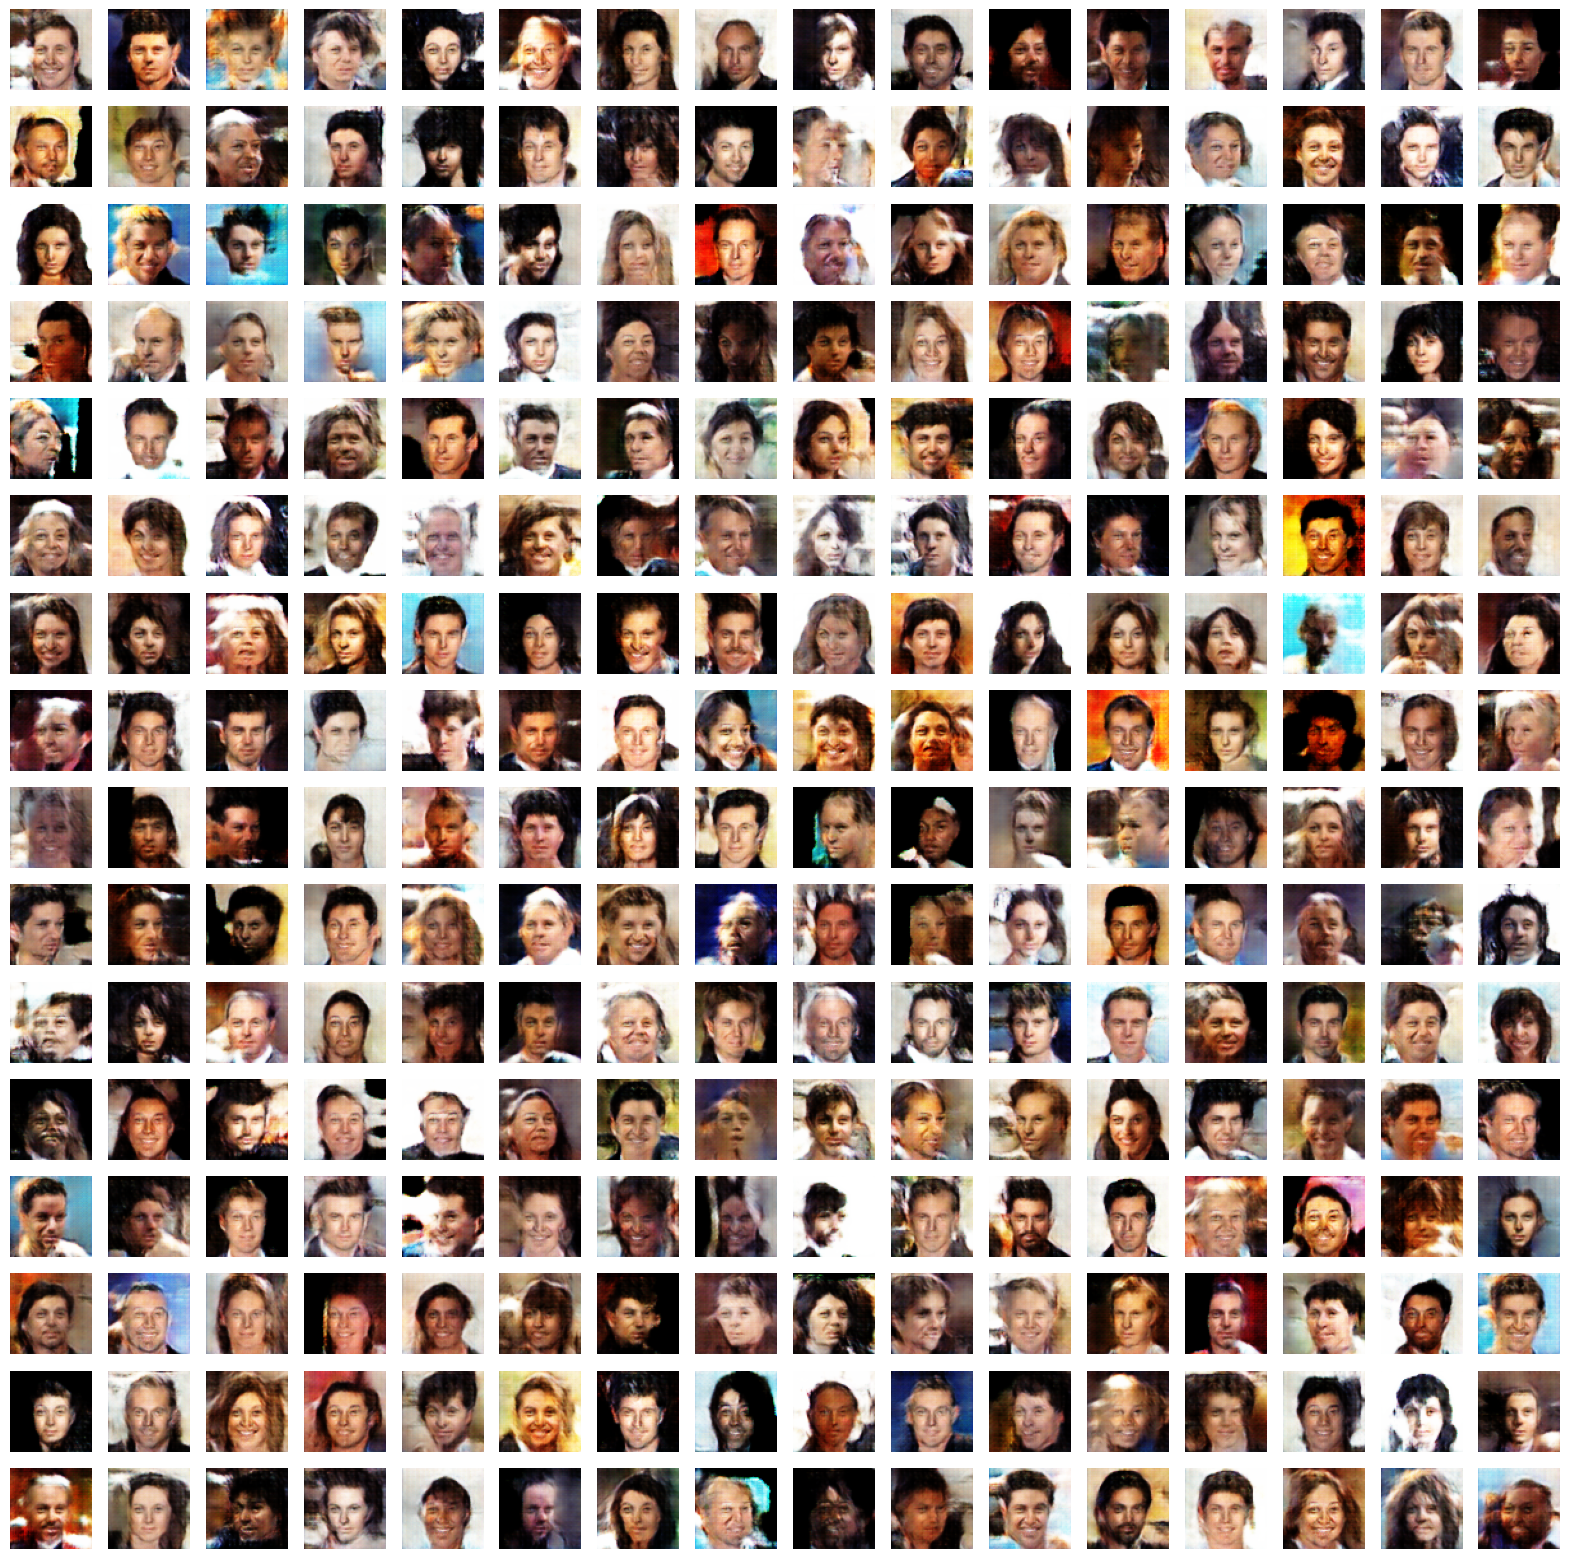

done


In [ ]:
noise = torch.randn((NUM_ROWS * NUM_COLS, LATENT_VECTOR_DIM, 1, 1), device=device)
IMAGE_SIZE = (3, 64, 64)
with torch.inference_mode():
    faces = generator(noise).reshape(NUM_ROWS, NUM_COLS, *IMAGE_SIZE).cpu()

plt.clf()
_, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(20,20))

for (faces_row, axes_row) in zip(faces, axes):
    for (face, ax) in zip(faces_row, axes_row):
        face_to_imshow = unnormalize_img(face, mean=MEAN, std=STD).detach()
        face_to_imshow = face_to_imshow.permute(1, 2, 0).numpy()
        ax.imshow(face_to_imshow)
        ax.axis("off")
plt.show()

print("done")